In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.neighbors._kde import KernelDensity
from sklearn.decomposition import PCA

import warnings

warnings.simplefilter("ignore")

In [3]:
df = pd.read_csv(
    "../data/watertreatment_mod.csv", encoding="shift_jis", header=0, index_col=0
)

In [4]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38
date,,,,,,,,,,,,,,,,,,,,,
D-5/3/90,35023,3.5,7.9,205,588,192,65.6,4.5,2430,7.8,...,1840,33.1,64.2,95.3,87.3,72.3,90.2,82.3,89.6,100.0
D-11/3/90,29156,2.5,7.7,206,451,194,69.1,4.5,1249,7.7,...,1338,46.1,43.6,92.5,85.6,58.2,92.2,73.8,90.2,99.4
D-12/3/90,39246,2.0,7.8,172,506,200,69.0,5.0,1865,7.8,...,1616,21.2,59.7,90.8,88.4,66.1,89.0,69.0,86.5,99.6
D-13/3/90,42393,0.7,7.9,189,478,230,67.0,5.5,1410,8.1,...,1575,0.6,45.8,92.0,11.6,25.7,19.6,36.0,43.0,36.4
D-18/3/90,40923,3.5,7.6,146,329,188,57.4,2.5,1300,7.6,...,1545,32.7,33.3,90.0,82.6,61.3,87.0,71.4,78.2,99.2


In [5]:
# 分割ポイント
split_point = 100
# 学習データ（train）と評価データ（test）に分割
train_df = df.iloc[
    : (split_point - 1),
]
test_df = df.iloc[
    split_point:,
]

In [6]:
# データを標準化
sc = StandardScaler()
sc.fit(train_df)
train_df_std = sc.transform(train_df)

In [7]:
# PCA
pca = PCA()
pca.fit(train_df_std)

PCA()

PCA(n_components=15)

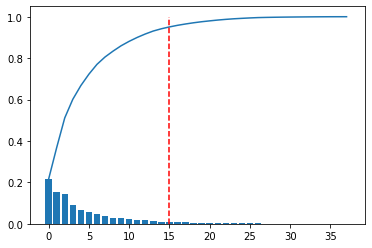

In [8]:
# Bar plot
plt.figure()
variance = pca.explained_variance_ratio_
variance_total = np.zeros(np.shape(variance)[0])
plt.bar(range(np.shape(variance)[0]), variance)
for i in range(np.shape(variance)[0]):
    variance_total[i] = np.sum(variance[0 : i + 1])

plt.plot(variance_total)
NumOfScore = np.min(np.where(variance_total > 0.95))
x1 = [NumOfScore, NumOfScore]
y1 = [0, 1]
plt.plot(x1, y1, ls="--", color="r")

pca = PCA(n_components=NumOfScore)
pca.fit(train_df_std)

In [9]:
# Compute SPE
scores = pca.transform(train_df_std)
residuals = pca.inverse_transform(scores) - train_df_std
dist = np.sqrt(np.sum(np.power(residuals, 2), axis=1)) / (np.shape(train_df_std)[1])

In [10]:
# データを標準化
test_df_std = sc.transform(test_df)
# Test Data
newscores = pca.transform(test_df_std)
newresiduals = pca.inverse_transform(newscores) - test_df_std
newdist = np.sqrt(np.sum(np.power(newresiduals, 2), axis=1)) / (
    np.shape(test_df_std)[1]
)

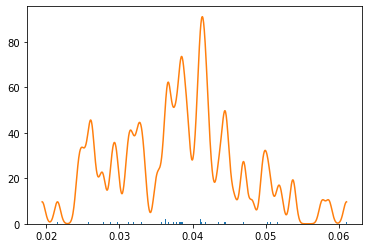

In [11]:
# コントロールリミット（カーネル密度推定）
cr = 0.99
X = dist.reshape(np.shape(dist)[0], 1)
bw = (np.max(X) - np.min(X)) / 100
kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(X)
X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.figure()
plt.hist(X, bins=X_plot[:, 0])
plt.plot(X_plot[:, 0], np.exp(log_dens))
prob = np.exp(log_dens) / np.sum(np.exp(log_dens))
calprob = np.zeros(np.shape(prob)[0])
calprob[0] = prob[0]
for i in range(1, np.shape(prob)[0]):
    calprob[i] = calprob[i - 1] + prob[i]

cl = X_plot[np.min(np.where(calprob > cr))]

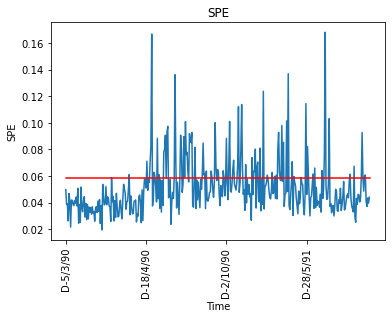

<Figure size 432x288 with 0 Axes>

In [12]:
# plot SPE
SPE = np.r_[dist, newdist]
plt.figure()
x = range(0, np.shape(df.index)[0], 100)
NewTimeIndices = np.array(df.index[x])
x2 = [0, np.shape(SPE)[0]]
y2 = [cl, cl]
plt.title("SPE")
plt.plot(SPE)
plt.xticks(x, NewTimeIndices, rotation="vertical")
plt.plot(x2, y2, ls="-", color="r")
# plt.ylim([0,1])
plt.xlabel("Time")
plt.ylabel("SPE")

# contribution plot
plt.figure()
total_residuals = np.r_[residuals, newresiduals]
CspeTimeseries = np.power(total_residuals, 2)

cspe_summary = np.zeros([np.shape(CspeTimeseries)[0], 10])

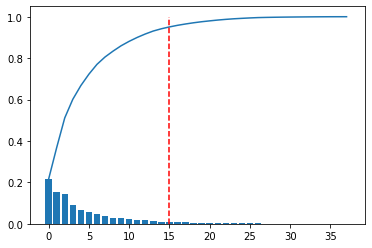

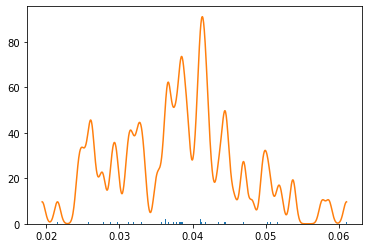

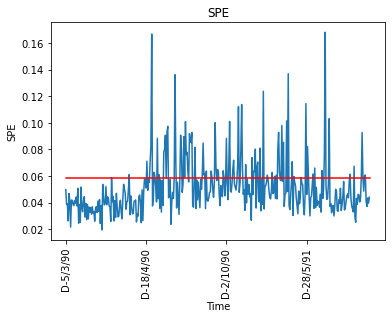

<Figure size 432x288 with 0 Axes>

In [13]:
# 必要なライブラリーのインポート
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.neighbors._kde import KernelDensity
from sklearn.decomposition import PCA


def preprocess_sc(df, split_point):
    """データを学習データと評価データに分割し、標準化を行う

    Parameters
    ----------
    df : pd.DataFrame
        データセット
    split_point : float
        データの分割ポイント（今回は恣意的に決定するため必要）

    Returns
    -------
    train_df_std : pd.DataFrame
        標準化後の学習データ
    test_df_std : pd.DataFrame
        標準化後の評価データ
    """
    # 学習データ（train）と評価データ（test）に分割
    train_df = df.iloc[
        : (split_point - 1),
    ]
    test_df = df.iloc[
        split_point:,
    ]

    # データを標準化
    sc = StandardScaler()
    sc.fit(train_df)
    train_df_std = sc.transform(train_df)
    test_df_std = sc.transform(test_df)

    return train_df_std, test_df_std


def pca_q(train_df_std, test_df_std):
    """主成分分析を行いQ統計量を求める

    Parameters
    ----------
    train_df_std : pd.DataFrame
        標準化後の学習データ
    test_df_std : pd.DataFrame
        標準化後の評価データ

    Returns
    -------
    dist : np.array
        学習データのQ統計量
    newdist : np.array
        評価データのQ統計量
    """
    # PCA
    pca = PCA()
    pca.fit(train_df_std)

    # 累積寄与率の計算と可視化
    plt.figure()
    variance = pca.explained_variance_ratio_
    variance_total = np.zeros(np.shape(variance)[0])
    plt.bar(range(np.shape(variance)[0]), variance)
    for i in range(np.shape(variance)[0]):
        variance_total[i] = np.sum(variance[0 : i + 1])

    plt.plot(variance_total)
    NumOfScore = np.min(np.where(variance_total > 0.95))
    x1 = [NumOfScore, NumOfScore]
    y1 = [0, 1]
    plt.plot(x1, y1, ls="--", color="r")

    pca = PCA(n_components=NumOfScore)
    pca.fit(train_df_std)

    # Q統計量
    scores = pca.transform(train_df_std)
    residuals = pca.inverse_transform(scores) - train_df_std
    dist = np.sqrt(np.sum(np.power(residuals, 2), axis=1)) / (np.shape(train_df_std)[1])

    # Test Data
    newscores = pca.transform(test_df_std)
    newresiduals = pca.inverse_transform(newscores) - test_df_std
    newdist = np.sqrt(np.sum(np.power(newresiduals, 2), axis=1)) / (
        np.shape(test_df_std)[1]
    )

    return dist, newdist


def cl_limit(dist, cr=0.99):
    """管理限界の計算を行う

    Parameters
    ----------
    dist : np.array
        Q統計量
    cr : float
        管理限界の境界

    Returns
    -------
    cl : float
        管理限界の境界点
    """
    cr = 0.99
    X = dist.reshape(np.shape(dist)[0], 1)
    bw = (np.max(X) - np.min(X)) / 100
    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(X)
    X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    plt.figure()
    plt.hist(X, bins=X_plot[:, 0])
    plt.plot(X_plot[:, 0], np.exp(log_dens))
    prob = np.exp(log_dens) / np.sum(np.exp(log_dens))
    calprob = np.zeros(np.shape(prob)[0])
    calprob[0] = prob[0]
    for i in range(1, np.shape(prob)[0]):
        calprob[i] = calprob[i - 1] + prob[i]

    cl = X_plot[np.min(np.where(calprob > cr))]

    return cl


def spe_plot(df, dist, newdist, cl):
    """Q統計量を可視化する

    Parameters
    ----------
    df : pd.DataFrame
        データセット
    dist : np.array
        学習データのQ統計量
    newdist : np.array
        評価データのQ統計量
    cl : float
        管理限界の境界点

    Returns
    -------
    train_df_std : pd.DataFrame
        標準化後の学習データ
    test_df_std : pd.DataFrame
        標準化後の評価データ
    """
    # Q統計量のプロット
    SPE = np.r_[dist, newdist]
    plt.figure()
    x = range(0, np.shape(df.index)[0], 100)
    NewTimeIndices = np.array(df.index[x])
    x2 = [0, np.shape(SPE)[0]]
    y2 = [cl, cl]
    plt.title("SPE")
    plt.plot(SPE)
    plt.xticks(x, NewTimeIndices, rotation="vertical")
    plt.plot(x2, y2, ls="-", color="r")
    plt.xlabel("Time")
    plt.ylabel("SPE")

    # contribution plot
    plt.figure()
    total_residuals = np.r_[residuals, newresiduals]
    CspeTimeseries = np.power(total_residuals, 2)

    cspe_summary = np.zeros([np.shape(CspeTimeseries)[0], 10])


def main():
    # データセットの読込み
    df = pd.read_csv(
        "../data/watertreatment_mod.csv", encoding="shift_jis", header=0, index_col=0
    )

    train_df_std, test_df_std = preprocess_sc(df, split_point)
    dist, newdist = pca_q(train_df_std, test_df_std)
    cl = cl_limit(dist, cr=0.99)
    spe_plot(df, dist, newdist, cl)


if __name__ == "__main__":
    main()